<a href="https://colab.research.google.com/github/AehLane/BoneTrade-Project-OSLNN/blob/master/Human_Remains_OSLNN_combined_(deprecated).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One Shot Learning with Siamese Networks

Code adapated from Harshvardhan Gupta, 2017 [One Shot Learning With Siamese Networks](https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb) and discussed in 
Graham and Huffer, Can One-Shot Learning Identify Origins of Human Remains Shown on Social Media? 


---

We're assuming you have loaded this notebook with Google Colab and that you are signed into a Google account. You run each block of code in sequential order the first time through. If after having trained a network you wish to resume testing at a later date, we show you how to save your model and reload it, at the appropriate blocks.

## Hardware Acceleration

Under 'Edit' -> 'Notebook Settings' make sure to select 'GPU' for Hardware Acceleration. The next block of code double-checks to make sure you've got GPU selected. 

In [0]:
try:
    %tensorflow_version 2.x
except:
    pass

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


## Load your data

There are a variety of ways to get your data into this notebook. The easiest are to upload directly, or to connect your Google Drive account. If you connect your Google Drive account, it will appear as a folder within the tray. You can right-click on a folder within your drive, copy the path, and then paste that into your code. Note that you'll have to delete the leading `/content/` from the path. 

**We are assuming that you have zipped a folder called `data` with two subfolders `testing` and `training`, and within each of those folders, one folder per class of _item_ you wish to train on/test.**

**To upload** open the tray at left by clicking on the `>` button. Select 'Files' and then 'Upload'. You can then select a zip file from your machine. The tray does not refresh automatically, so you'll need to hit 'refresh' periodically.

Then, unzip the data by running the next block. If you're using Google drive, skip to the next block.

In [0]:
# If I'm uploading
!unzip data.zip -d data/

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


**To mount your Google drive** run the next block of code. The results block will display a URL. Click on this, and a new window will open, confirming that you want to connect your drive. Once you've confirmed, an authorization code will be displayed. Copy this code, and paste into the results block. If all goes well, the results block will shortly display the text, 'Mounted at /content/drive'. Refresh the files pane in the tray at left, and you will see it there.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In the two blocks below, we show you how to copy a file from your drive to this space, how to make a new directory (`mkdir`) and how to unzip a folder into that new directory.

In [0]:
# If you have data already on google drive
!cp "drive/My Drive/one-shot-test/data_copy_with_equal_augs.zip" data.zip

In [0]:
# Upload data from local machine then:
# !mkdir data && unzip data.zip -d data/
!unzip data.zip 

# Or copy it over from google drive

Archive:  data.zip
   creating: data_copy_with_equal_augs/
   creating: data_copy_with_equal_augs/data/
  inflating: data_copy_with_equal_augs/data/.DS_Store  
   creating: data_copy_with_equal_augs/data/testing/
  inflating: data_copy_with_equal_augs/data/testing/.DS_Store  
   creating: data_copy_with_equal_augs/data/testing/11324-dh/
  inflating: data_copy_with_equal_augs/data/testing/11324-dh/Screen_Shot_2019-06-20_at_1-removebg-preview.png  
   creating: data_copy_with_equal_augs/data/testing/afr-f-moraitas/
  inflating: data_copy_with_equal_augs/data/testing/afr-f-moraitas/african-f-moraitas.png  
   creating: data_copy_with_equal_augs/data/testing/asian-f-moraitas/
 extracting: data_copy_with_equal_augs/data/testing/asian-f-moraitas/asian-f-moraitas.png  
   creating: data_copy_with_equal_augs/data/testing/asian-f-woo/
 extracting: data_copy_with_equal_augs/data/testing/asian-f-woo/asian-f-woo.png  
   creating: data_copy_with_equal_augs/data/testing/asian-m-woo/
  inflating: da

---
## Imports

We now need to import some libraries that we will use to build the neural network.


In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from scipy.spatial.distance import pdist

#!pip install tensorflow-addons
#import tensorflow_addons as tfa

## Helper functions

Here we create two helper functions, `imshow` and `show_plot`. 

In [0]:
def imshow(img,text=None, text2=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(10, 10, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    if text2:
        plt.text(120, 10, text2, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Defining Dataloader workers' init()

We specify an init function, "__worker_init_fn__" to split the task of generating anchor-unknown pairs among a group of workers. This function is provided as an argument for __DataLoaders__, giving the dataloader an init method for its workers.

In [0]:
def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()
    dataset = worker_info.dataset

    dataset.worker_unique_id = worker_info.id
    dataset.number_of_workers = worker_info.num_workers
    dataset.anchor_iter_index = torch.tensor(worker_info.id)
    dataset.unknown_iter_index = torch.tensor(worker_info.id)

## Configuration class

We now create a class to configure some variables we will be reusing. 

In [0]:
class Config():
    training_dir = "/content/data_copy_with_equal_augs/data/training"
    testing_dir = "/content/data_copy_with_equal_augs/data/testing"
    train_batch_size = 64
    train_number_epochs = 100
    num_generator_workers = 1

## Custom dataset class

Under a superclass of "__SiameseNetworkDataset__", two subclasses exist for different purposes; training and testing.

For "__PairwiseTrainingSiameseNetworkDataset__", we set up the code to generates a pair of images from our training dataset, 0 for geniune pair and 1 for imposter pair. It goes through the training directory, pairing images and assuming that images within a subfolder are similar and images from different subfolders are different. This is also where we attach filenames to the images so that when we are testing later we know which pairs of images we're dealing with. This addition to the original code, the class implementation now residing under "__PairwiseTrainingSiameseNetworkDataset__", is courtesy of Tim Sherratt with modifications by Alex Lane.

__Note:__ If the training dataset subdirectories do not have the same number of images in each subdirectory, "__PairwiseTrainingSiameseNetworkDataset__" will select pairs with more bias. Over a large number of pairs, more pairs containing images from subdirectories with less images will be generated. It is advised that the subdirectories have a uniform number of images within to ensure random selection.

For "__PairwiseTestingSiameseNetworkDataset__", "__getitem__" returns a valid anchor-unknown pair of images. Since the data is kept as a generator due to possibly working with large sets of data, the runtime should be __O(n^2)__ due to iteratively comparing each element of the dataset to each potential pair member in the same dataset.

In [0]:
import imgaug as ia
from imgaug import augmenters as iaa
import imageio

def generate_positive(anchor_img_path):
    random.seed()
    t = int(random.randint(0, 100000))
    #print(t)
    ia.seed(t)

    #print("before read")
    #print(anchor_img_path)
    img = imageio.imread(anchor_img_path) #read you image
    #print("after read")
    images = np.array(
        [img for _ in range(1)], dtype=np.uint8)  # 32 means creat 32 enhanced images using following methods.

    seq = iaa.Sequential(
        [
            iaa.Fliplr(0.5),  
            iaa.Crop(percent=(0, 0.1)),            
            iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),        
            iaa.ContrastNormalization((0.75, 1.5)),         
            iaa.AdditiveGaussianNoise(
                loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),    
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            iaa.Affine(
                scale={
                    "x": (0.8, 1.2),
                    "y": (0.8, 1.2)
                },
                translate_percent={
                    "x": (-0.2, 0.2),
                    "y": (-0.2, 0.2)
                },
                rotate=(-25, 25),
                shear=(-8, 8))
        ],
        random_order=True)  # apply augmenters in random order

    images_aug = seq.augment_images(images)
    pos_img = Image.fromarray(images_aug[0])

    #imshow(torchvision.utils.make_grid(pos_img))

    return pos_img
    #imageio.imwrite(anchor_img_path+'_generated_positive.png', images_aug[0])

    

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __len__(self):
        return len(self.imageFolderDataset.imgs)


class PairwiseTrainingSiameseNetworkDataset(SiameseNetworkDataset):

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        # We need to make sure approx 50% of images are in the same class
        should_get_same_class = bool(random.getrandbits(1)) 

        num_pos_images = (len(self.imageFolderDataset.imgs)
            /len(self.imageFolderDataset.class_to_idx))
        if should_get_same_class:
            while True:
            #    # Keep looping till the same class image is found
            #   img1_tuple = random.choice(self.imageFolderDataset.imgs) 
            #   if img0_tuple[1]==img1_tuple[1]:
            #       break
                if (img0_tuple != self.imageFolderDataset.imgs[random.randrange((img0_tuple[1]*num_pos_images),((img0_tuple[1]+1)*num_pos_images))]):
                    img1_tuple = self.imageFolderDataset.imgs[random.randrange((img0_tuple[1]*num_pos_images),((img0_tuple[1]+1)*num_pos_images))]
                    break;
        else:
            #while True:
            #    # Keep looping till a different class image is found
            #    img1_tuple = random.choice(self.imageFolderDataset.imgs) 
            #    if img0_tuple[1] !=img1_tuple[1]:
            #        break
            size_first_neg_range = img0_tuple[1]*num_pos_images
            size_second_neg_range = len(self.imageFolderDataset.imgs) - ((img0_tuple[1]+1)*num_pos_images)

            total_random_neg_indices = size_first_neg_range+size_second_neg_range
            neg_index_chosen = int(total_random_neg_indices * random.random())
            if(neg_index_chosen < size_first_neg_range):
                img1_tuple = self.imageFolderDataset.imgs[int(neg_index_chosen)]
            else:
                img1_tuple = self.imageFolderDataset.imgs[int(neg_index_chosen+num_pos_images)]


        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
            
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        # return img0, img1 , torch.from_numpy(
            # np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
		# Courtesy of Tim Sherrat
        # The new return line
		# Note the addition of img0_tuple[0], img1_tuple[0] which contain the 
        # paths
        #print(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        return (img0,
                img1,
                torch.from_numpy(
                    np.array(
                        [int(img1_tuple[1]!=img0_tuple[1])],
                        dtype=np.float32)),
                img0_tuple[0],
                img1_tuple[0])


class TripletTrainingSiameseNetworkDataset(SiameseNetworkDataset):

    # Returns an anchor image, a positive image (in the same class), and a 
    # negative image (in a different class)
    def __getitem__(self, index):



        # First, we select a random image to be our anchor
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #print(img0_tuple)

        # Secondly, we select a random image in the same class as our positive
        num_pos_images = (len(self.imageFolderDataset.imgs)
            /len(self.imageFolderDataset.class_to_idx))
        img1_tuple = self.imageFolderDataset.imgs[random.randrange((img0_tuple[1]*num_pos_images),((img0_tuple[1]+1)*num_pos_images))]

        #Thirdly, we select a random image in a different class as the negative
        size_first_neg_range = img0_tuple[1]*num_pos_images
        size_second_neg_range = len(self.imageFolderDataset.imgs) - ((img0_tuple[1]+1)*num_pos_images)

        total_random_neg_indices = size_first_neg_range+size_second_neg_range
        neg_index_chosen = int(total_random_neg_indices * random.random())
        if(neg_index_chosen < size_first_neg_range):
            img2_tuple = self.imageFolderDataset.imgs[int(neg_index_chosen)]
        else:
            img2_tuple = self.imageFolderDataset.imgs[int(neg_index_chosen+num_pos_images)]

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img2 = Image.open(img2_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        img2 = img2.convert("L")
            
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
            img2 = PIL.ImageOps.invert(img2)

        print(img0)
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        print(img0)
        print(img0.shape)
        '''
        print("anchor")
        print(img0_tuple[0])
        print("pos")
        print(img1_tuple[0])
        print("neg")
        print(img2_tuple[0])
        '''

        return (img0,
                img1,
                img2,
                img0_tuple[0],
                img1_tuple[0],
                img2_tuple[0])


class BatchTripletSiameseNetworkDataset(SiameseNetworkDataset):

    # Returns an anchor image, a positive image (in the same class), and a 
    # negative image (in a different class)
    def __getitem__(self, index):

        # First, we select a random image to be our anchor
        randIndex = random.randrange(0, len(self.imageFolderDataset.imgs))
        img0_tuple = self.imageFolderDataset.imgs[randIndex]
        #print(img0_tuple)

        img0 = Image.open(img0_tuple[0])
        img0 = img0.convert("L")
            
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)

        if self.transform is not None:
            img0 = self.transform(img0)
        '''
        print("anchor")
        print(img0_tuple[0])
        print("pos")
        print(img1_tuple[0])
        print("neg")
        print(img2_tuple[0])
        '''

        return (img0,
                img0_tuple)

        

class TripletTestingSiameseNetworkDataset(SiameseNetworkDataset):

    def __init__(
            self,
            imageFolderDataset,transform,should_invert,
            anchor_index,unknown_iter_index=0,
            anchor_file_identifier='',
            worker_unique_id=0,
            number_of_workers=1):
        super().__init__(imageFolderDataset,transform,should_invert)
        self.anchor_iter_index = anchor_index
        self.unknown_iter_index = unknown_iter_index
        self.anchor_file_identifier = anchor_file_identifier
        self.worker_unique_id = worker_unique_id
        self.number_of_workers = number_of_workers

    # Returns an anchor image, a positive image (in the same class), and a 
    # negative image (in a different class)
    def __getitem__(self, index):

        #print(self.anchor_iter_index)
        #print("before img0")
        img0_tuple = self.imageFolderDataset.imgs[self.anchor_iter_index.item()]
        img1_tuple = self.imageFolderDataset.imgs[self.anchor_iter_index.item()]
        #print(self.anchor_iter_index)
        #print(type(img0_tuple))
        #print(img0_tuple)
        #print("after img0")

        # Secondly, we select a random image in the same class as our positive
        #print("before img1")
        #img1 = generate_positive(img0_tuple)
        #print(type(img1))
        #print(img1)
        #print("after img1")

        #print(self.imageFolderDataset.class_to_idx)
              
        while self.unknown_iter_index < len(self):
            if (
                    not self.anchor_file_identifier 
                    in self.imageFolderDataset.imgs[self.unknown_iter_index][0]
                ):
                img2_tuple = (
                    self.imageFolderDataset.imgs[self.unknown_iter_index])
                break
            else:
                self.unknown_iter_index += self.number_of_workers

        if self.unknown_iter_index >= len(self):
            self.unknown_iter_index = 0
            return -1, self.worker_unique_id, -1, -1, -1, -1, -1
        else:
            self.unknown_iter_index += self.number_of_workers

            #print(img0_tuple[0])
            #print(img1_tuple[0])
            img1 = generate_positive(img1_tuple[0])

            img0 = Image.open(img0_tuple[0])
            #img1 = Image.open(img1)
            img2 = Image.open(img2_tuple[0])
            img0 = img0.convert("L")
            img1 = img1.convert("L")
            img2 = img2.convert("L")
            
            if self.should_invert:
                img0 = PIL.ImageOps.invert(img0)
                img1 = PIL.ImageOps.invert(img1)
                img2 = PIL.ImageOps.invert(img2)

            if self.transform is not None:
                img0 = self.transform(img0)
                img1 = self.transform(img1)
                img2 = self.transform(img2)
            '''
            print("anchor")
            print(img0_tuple[0])
            print("pos")
            print(img1_tuple[0])
            print("neg")
            print(img2_tuple[0])
            '''

            return (self.anchor_iter_index,
                    self.worker_unique_id,
                    img0, 
                    img1,
                    img2,  
                    img0_tuple[0],
                    img2_tuple[0])

        

class PairwiseTestingSiameseNetworkDataset(SiameseNetworkDataset):

    def __init__(
            self,
            imageFolderDataset,
            transform,should_invert,
            anchor_iter_index,
            unknown_iter_index=0,
            anchor_file_identifier='',
            worker_unique_id=0,
            number_of_workers=1):
        super().__init__(imageFolderDataset,transform,should_invert)
        self.anchor_iter_index = anchor_iter_index
        self.unknown_iter_index = unknown_iter_index
        self.anchor_file_identifier = anchor_file_identifier
        self.worker_unique_id = worker_unique_id
        self.number_of_workers = number_of_workers

    def __getitem__(self,index):
        #print(self.imageFolderDataset.classes)
        while self.anchor_iter_index < len(self):
            if (
                    self.anchor_file_identifier 
                    in self.imageFolderDataset.imgs[self.anchor_iter_index][0]):
                img0_tuple = (
                    self.imageFolderDataset.imgs[self.anchor_iter_index])
                break
            else:
                self.anchor_iter_index += self.number_of_workers

        if self.anchor_iter_index >= len(self):
            return -1, -1, -1, -1, -1, -1
        else:
            self.anchor_iter_index += self.number_of_workers
            #print(self.anchor_iter_index)
            img0 = Image.open(img0_tuple[0])
            img0 = img0.convert("L")
            
            if self.should_invert:
                img0 = PIL.ImageOps.invert(img0)

            if self.transform is not None:
                img0 = self.transform(img0)
            #print(self.anchor_iter_index)
            return (self.anchor_iter_index.item()-self.number_of_workers,
                    self.worker_unique_id,
                    img0,
                    -1 ,
                    img0_tuple[0],
                    -1)


class PairwiseTestingSiameseNetworkDataset2(SiameseNetworkDataset):

    def __init__(
            self,
            imageFolderDataset,transform,should_invert,
            anchor_iter_index,unknown_iter_index=0,
            anchor_file_identifier='',
            worker_unique_id=0,
            number_of_workers=1):
        super().__init__(imageFolderDataset,transform,should_invert)
        self.anchor_iter_index = anchor_iter_index
        self.unknown_iter_index = unknown_iter_index
        self.anchor_file_identifier = anchor_file_identifier
        self.worker_unique_id = worker_unique_id
        self.number_of_workers = number_of_workers

    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset.imgs[self.anchor_iter_index]
              
        while self.unknown_iter_index < len(self):
            if (
                    not self.anchor_file_identifier 
                    in self.imageFolderDataset.imgs[self.unknown_iter_index][0]
                ):
                img1_tuple = (
                    self.imageFolderDataset.imgs[self.unknown_iter_index])
                break
            else:
                self.unknown_iter_index += self.number_of_workers

        if self.unknown_iter_index >= len(self):
            self.unknown_iter_index = 0
            return -1, self.worker_unique_id, -1, -1, -1, -1
        else:
            self.unknown_iter_index += self.number_of_workers

            img0 = Image.open(img0_tuple[0])
            img1 = Image.open(img1_tuple[0])
            img0 = img0.convert("L")
            img1 = img1.convert("L")
            
            if self.should_invert:
                img0 = PIL.ImageOps.invert(img0)
                img1 = PIL.ImageOps.invert(img1)

            if self.transform is not None:
                img0 = self.transform(img0)
                img1 = self.transform(img1)

            return (self.index,
                    self.worker_unique_id,
                    img0, 
                    img1 , 
                    img0_tuple[0], 
                    img1_tuple[0])



## Setting the image folder to be used by the custom dataset

In the first block, we specify the location of the training data. In the second block, we pass the images through the custom dataset class,  resizing them to 100 x 100 pixels, transforming them into tensors.

In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
print(folder_dataset.imgs)

[('/content/data_copy_with_equal_augs/data/training/alleged_malay_female/0new.png', 0), ('/content/data_copy_with_equal_augs/data/training/alleged_malay_female/10new.png', 0), ('/content/data_copy_with_equal_augs/data/training/alleged_malay_female/11new.png', 0), ('/content/data_copy_with_equal_augs/data/training/alleged_malay_female/12new.png', 0), ('/content/data_copy_with_equal_augs/data/training/alleged_malay_female/13new.png', 0), ('/content/data_copy_with_equal_augs/data/training/alleged_malay_female/14new.png', 0), ('/content/data_copy_with_equal_augs/data/training/alleged_malay_female/15new.png', 0), ('/content/data_copy_with_equal_augs/data/training/alleged_malay_female/16new.png', 0), ('/content/data_copy_with_equal_augs/data/training/alleged_malay_female/17new.png', 0), ('/content/data_copy_with_equal_augs/data/training/alleged_malay_female/18new.png', 0), ('/content/data_copy_with_equal_augs/data/training/alleged_malay_female/19new.png', 0), ('/content/data_copy_with_equal_

In [0]:
pairwise_siamese_dataset = PairwiseTrainingSiameseNetworkDataset(
    imageFolderDataset=folder_dataset,
    transform=transforms.Compose([transforms.Resize((100,100)),
                                  transforms.ToTensor()]),
    should_invert=False)

In [0]:
triplet_siamese_dataset = BatchTripletSiameseNetworkDataset(
    imageFolderDataset=folder_dataset,
    transform=transforms.Compose([transforms.Resize((100,100)),
                                  transforms.ToTensor()]),
    should_invert=False)

## Visualising some of the training data

The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image. 1 indiciates dissimilar, and 0 indicates similar.


In [0]:
vis_dataloader = DataLoader(pairwise_siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Create the neural network

We will use a standard convolutional neural network. Each convolutional layer has batch normalisation and then dropout. As Gupta says, 'There is nothing special about this network. It accepts an input of 100px by 100px and has 3 full connected layers after the convolution layers'. This might be where you want to experiment, eventually, with adding more layers and so on.

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
        

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, Config.train_batch_size))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input):
        output = self.forward_once(input)
        return output

## Contrastive loss function

Here we define the contrastive loss.

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(
            output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

## Triplet loss function

Here we define the triplet loss.

In [0]:
class TripletLoss(torch.nn.Module):

    def forward(self, anchor_embed, pos_embed, neg_embed):
        #print(anchor_embed.type())
        #print(pos_embed.type())
        #print(anchor_embed)
        #print(anchor_embed**2)
        d_pos = torch.sum((anchor_embed - pos_embed)**2, 1)
        d_neg = torch.sum((anchor_embed - neg_embed)**2, 1)
        zero = torch.zeros([1], dtype=torch.float32)
        zero = zero.cuda()
        #print(2.0 + (d_pos - d_neg))
        loss_triplet = torch.max(zero, 1.0 + (d_pos - d_neg))
        #print(loss_triplet)
        loss_triplet = torch.mean(loss_triplet)
        #print(loss_triplet)
        return loss_triplet


def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss


## Training the neural network

The next three blocks configure all of the variables and settings for training the neural network. You might want to experiment with changing the values of the Adam optimizer.

In [0]:
train_dataloader = DataLoader(
    pairwise_siamese_dataset,
    shuffle=False,
    num_workers=Config.num_generator_workers,
    batch_size=Config.train_batch_size)

In [0]:
train_dataloader = DataLoader(
    triplet_siamese_dataset,
    shuffle=False,
    num_workers=Config.num_generator_workers,
    batch_size=1)

net = SiameseNetwork().cuda()
criterion = TripletLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.00006, betas=(0.9,0.999), eps=1e-8 )

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.00006 )

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

### Start the training

This next block will start the training for the number of epochs set at the start of the notebook in the configuration block. The code is slightly modified so that filenames get stored for the images.

In [0]:

for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
		# Modifications by Tim Sherrat, to enable path printing
        # Note the underscores! They're the path values, 
        # which we don't actually want here
		# Underscores are used as variable names for things we don't actually 
        # want
        img0, img1 , label, _, _ = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        #print(output1)
        #print(output2)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(
                epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [0]:
for epoch in range(0,Config.train_number_epochs):
    loss_triplet = 0
    for i, data in enumerate(train_dataloader,0):
		# Modifications by Tim Sherrat, to enable path printing
        # Note the underscores! They're the path values, 
        # which we don't actually want here
		# Underscores are used as variable names for things we don't actually 
        # want
        img0, img1 , img2, _, _, _ = data
        print(type(img0))
        print(img0.shape)
        img0, img1 , img2 = img0.cuda(), img1.cuda() , img2.cuda()
        optimizer.zero_grad()
        anchor_output,pos_output,neg_output = net(img0,img1,img2)
        #print(output1)
        #print(output2)
        loss_triplet = criterion(anchor_output,pos_output,neg_output)
        #print(loss_triplet)
        loss_triplet.backward()
        optimizer.step()
    print("Epoch number {}\n Current loss {}\n".format(
        epoch,loss_triplet.item()))
    iteration_number +=train_dataloader.batch_size
    counter.append(iteration_number)
    loss_history.append(loss_triplet.item())
show_plot(counter,loss_history)

In [0]:
training_images_dataset = folder_dataset.imgs
for epoch in range(0,Config.train_number_epochs):
    batch_tensor = torch.Tensor(0,Config.train_batch_size).cuda()
    batch_labels = torch.Tensor(0,).cuda()
    selected_images = []
    for i in range(0, Config.train_batch_size):
        while(True):
            #https://github.com/amdegroot/ssd.pytorch/issues/214
            try:
                potential_batch_sample, potential_name = next(batch_generator)
            except:
                batch_generator = iter(train_dataloader)
                potential_batch_sample, potential_name = next(batch_generator)
            if (potential_name[0] in selected_images):
                continue
            else:
                selected_images.append(potential_name[0])
                #print(potential_batch_sample[0])
                #print(type(potential_batch_sample[0][0]))
                #batch_sample = Image.open(potential_batch_sample[0][0])
                #batch_sample = batch_sample.convert("L")
                #transformToTensor = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])
                #batch_sample = transformToTensor(batch_sample)
                #batch_sample
                batch_sample = potential_batch_sample
                #print(type(batch_sample))
                #print(batch_sample.shape)
                #print(batch_sample)
                batch_sample = batch_sample.cuda()
                optimizer.zero_grad()
                batch_sample_embed = net(batch_sample)
                #print(type(batch_sample_embed))
                #print(batch_sample_embed.shape)
                #print(batch_sample_embed)
                #if (i == 0):
                #    batch_tensor = torch.cat((batch_tensor, batch_sample_embed), 0)
                #else:
                #    batch_tensor = torch.cat((batch_tensor, batch_sample_embed), 1)
                #print(batch_sample_embed.shape)
                #batch_sample_embed = batch_sample_embed.permute(1,0)
                #print(batch_sample_embed.shape)
                #print(batch_tensor.shape)
                #print(batch_sample_embed)
                batch_tensor = torch.cat((batch_tensor, batch_sample_embed), 0)
                #print(potential_name[1][0])
                batch_labels = torch.cat((batch_labels, ((potential_name[1]).float()).cuda()), 0)
                #print(batch_labels)
                #print(len(potential_label))
                #print(potential_label[0])
                #print(batch_tensor)
                #print(batch_tensor.shape)
                #print(batch_tensor)
                break
    print(batch_tensor.shape)
    print(batch_tensor[0])
    print(batch_labels.shape)
    print(batch_labels)

    hard_triplet_loss = batch_hard_triplet_loss(batch_labels, batch_tensor, margin=1.0)
    hard_triplet_loss.backward()
    optimizer.step()
    
    print("Next Epoch")



torch.Size([64, 64])
tensor([ 2.7974e-01,  1.1342e-01, -2.9552e-02,  1.0118e-01,  1.7365e-01,
         1.6830e-02, -3.9277e-03, -8.4284e-03,  1.5558e-01, -8.8690e-02,
        -2.8197e-02,  5.4402e-02,  6.2592e-02, -1.1741e-01,  1.0943e-01,
         1.2813e-04, -2.4864e-01,  1.3342e-01, -4.3571e-02,  3.0743e-02,
        -1.0595e-01,  1.2275e-01,  3.0823e-02, -9.0621e-02, -4.0151e-03,
         4.1188e-03, -4.7198e-02,  5.4582e-02,  2.2564e-01, -1.3963e-01,
         3.6481e-02, -1.2525e-01, -2.0841e-01, -3.2724e-03, -1.2440e-01,
         9.9648e-02, -1.8046e-01, -1.8490e-01, -6.7626e-02, -3.4208e-02,
        -2.0384e-01,  2.5269e-01,  3.3949e-02, -6.0381e-02,  8.8940e-02,
         5.9731e-02,  1.9918e-01, -8.8343e-03, -6.7095e-02, -4.9977e-02,
         1.2396e-01,  1.4249e-01, -7.2423e-02,  1.8932e-01,  1.0546e-01,
        -8.1234e-02, -2.8308e-02,  9.2901e-02,  2.4337e-02, -1.4357e-01,
        -1.0258e-01,  8.1700e-03,  9.5670e-02,  3.5610e-02], device='cuda:0',
       grad_fn=<SelectBac

ValueError: ignored

## Save the model

The block below saves the state dictionary, and the model. This is handy so that once you *have* a trained model, you can return to it if your notebook connection to Colab is broken, or if you have to set the project aside for a while. The second block copies (`cp`) the file to a location on Google drive. You can also download the file to your machine directly by right-clicking the filename in the tray at left (you might need to hit 'refresh' to see it, first).

In [0]:
# Save the model!
torch.save(net.state_dict(),'net_params.pkl')
torch.save(net, 'net.h5')

In [0]:
cp net_params.pkl "drive/My Drive/one-shot-test"

## Reloading the model at a later time

If this is your first time through the notebook, you don't need to worry about this; skip down to **Testing**. If you're returning to the project, make sure
+ that you've got hardware acceleration turned on
+ that you've run all of the code again to import the necessary libraries, and set the various configurations 
  + _including_ the SiameseNetwork class

The block below assumes you've connected Google drive. Alternatively you can upload directly.

In [0]:
# Copy the model back from your drive
!cp "drive/My Drive/one-shot-test/net_params.pkl" data/net_params.pkl

...then tell the machine to load the model:

In [0]:
# Load the model
net=SiameseNetwork()
net.load_state_dict(torch.load('data/net_params.pkl'))
dp = nn.DataParallel(net) #https://github.com/pytorch/pytorch/issues/3805

# The incompatiblekeys message might not be an issue - see
# https://gpytorch.readthedocs.io/en/latest/examples/00_Basic_Usage/Saving_and_Loading_Models.html 
# which replicates that incompatiblekeys message without any kind of comment, 
# seems to be hunkydory

## Testing

This block iteratively loads pairs of images with known provenance versus unknown provenance from different subfolders in your testing folder. It then compares the results of these anchor-unknown pairs using euclidean distance. It will print out the images with the dissimilarity distance, as well as printing out the filenames for each pair. You can experiment with printing these results to a file.

Since this code currently outputs all anchor-unknown pairs, the runtime is __O(n^2)__.

In [0]:
# Init variable representing testing data's directory, 
# see Config section to specify path
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)

# Create the dataset, pairwise_siamese_dataset_anchors, with data from the 
# testing data
# Then, create a generator with pairwise_siamese_dataset-unknowns
pairwise_siamese_dataset_anchors = PairwiseTestingSiameseNetworkDataset(
    imageFolderDataset=folder_dataset_test,
    transform=transforms.Compose([transforms.Resize((100,100)),
                                transforms.ToTensor()]),
    should_invert=False,
    anchor_iter_index=0, 
    anchor_file_identifier='ref-')

test_dataloader = DataLoader(
    pairwise_siamese_dataset_anchors,
    num_workers=Config.num_generator_workers,
    batch_size=1,
    shuffle=False,
    worker_init_fn=worker_init_fn)

generator_anchor_images = iter(test_dataloader)

workers_terminated_outer = np.zeros(Config.num_generator_workers)
# Outer loop searches for anchors
for i in range(len(generator_anchor_images)):

    # Returns a found anchor's index, image, and filepath
    anchor_index,worker_id_outer,anchor_image,_,anchor_filepath,_ = next(
        generator_anchor_images)
    # Stop outer loop if index is out of bounds, no more potential anchors
    if not(0 in workers_terminated_outer):
        break

    if anchor_index.item() < 0:
        np.put(workers_terminated_outer, worker_id_outer, 1)
    else:
        # Create new dataset with a given known anchor's index
        # Then, create a generator with pairwise_siamese_dataset-unknowns
        pairwise_siamese_dataset_unknowns = PairwiseTestingSiameseNetworkDataset2(
            imageFolderDataset=folder_dataset_test,
            transform=transforms.Compose([transforms.Resize((100,100)),
                                          transforms.ToTensor()]),
            should_invert=False,
            anchor_iter_index=anchor_index, 
            anchor_file_identifier='ref-')
      
        compare_dataloader = test_dataloader = DataLoader(
            pairwise_siamese_dataset_unknowns,
            num_workers=Config.num_generator_workers,
            batch_size=1,shuffle=False,
            worker_init_fn=worker_init_fn)
      
        generator_unknown_prov_images = iter(compare_dataloader)

        workers_terminated_inner = np.zeros(Config.num_generator_workers)
        # Inner loop pairs a known anchor with every image of unknown provenance
        for k in range(len(generator_unknown_prov_images)):
            # no_more_unknowns will return -1 if all pairs have been found
            no_more_unknowns,worker_id_inner,_,unknown_prov_image,_,unknown_prov_filepath = (
                next(generator_unknown_prov_images))

            # Stop this inner loop if all anchor-unknown pairs for the current 
            # anchor image are found
            if not(0 in workers_terminated_inner):
                break

            if no_more_unknowns.item() < 0:
                np.put(workers_terminated_inner, worker_id_inner, 1)
            else:
                concatenated = torch.cat((anchor_image,unknown_prov_image),0)

                # Again getting rid of cuda for my Mac
                output1,output2 = net(
                    Variable(anchor_image).cuda(),
                    Variable(unknown_prov_image).cuda())
                # output1,output2 = net(Variable(x0),Variable(x1))
                euclidean_distance = F.pairwise_distance(output1, output2)

                # Show the images:
                imshow(
                    torchvision.utils.make_grid(concatenated),
                    'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

                # Show the paths for the two images
                print('Image 1: {}'.format(anchor_filepath[0])) 
                print('Image 2: {}'.format(unknown_prov_filepath[0]))
                print('Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
                # Print out the results as a kind of table.
                # from tabulate import tabulate
                # print(tabulate([[p0, p1,euclidean_distance.item()]], 
                    # headers=['image1', 'image2','euclidean_distance']))
        
        # Ensures each worker generates unique pair
        # nth loop iteration 
        # * number of workers 
        # + this worker's ID (added in init)
        #next_index_to_check = Config.num_generator_workers+anchor_index.item()
        #anchor_index = torch.tensor(next_index_to_check)

print('Finshed all anchor-unknown pair comparisons')

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m

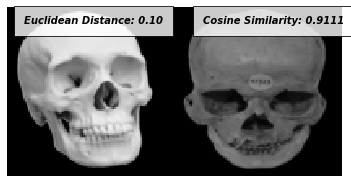

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/11324-dh/Screen_Shot_2019-06-20_at_1-removebg-preview.png


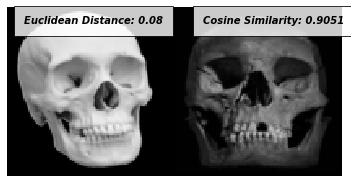

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/RichardIII/richardIII.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


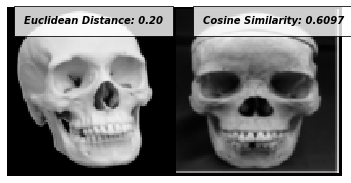

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/afr-f-moraitas/african-f-moraitas.png


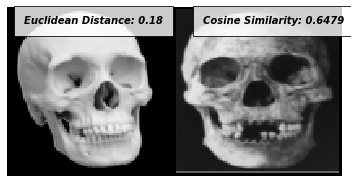

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-f-moraitas/asian-f-moraitas.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


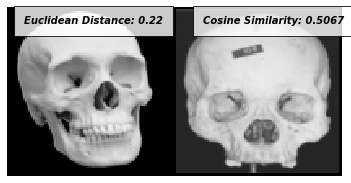

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-f-woo/asian-f-woo.png


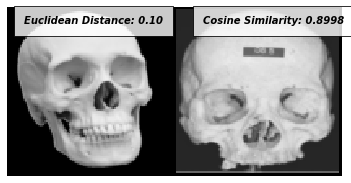

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-m-woo/asian-m-woo.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


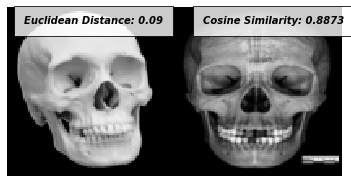

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-1-afr-am-f/cas-fig4-1-afr-am-f.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


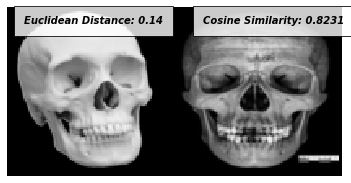

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-1-afr-am-m/cas-fig4-1-afr-am-m.png


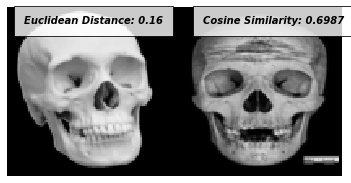

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-2-afr-f/cas-fig4-2-afr-f.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


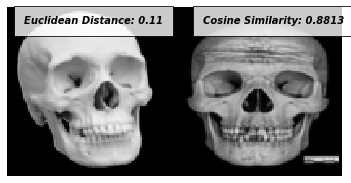

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-2-afr-m/cas-fig4-2-afr-m.png


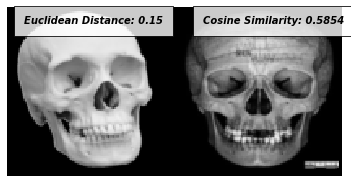

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-3-euro-am-f/cas-fig-4-3-euro-am-f.png


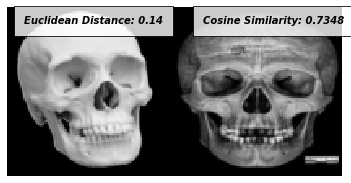

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-3-euro-am-m/cas-fig-4-3-euro-am-m.png


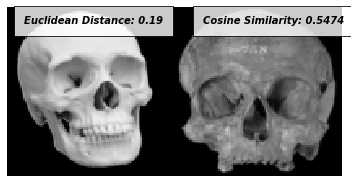

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/fountain-street-male/fountain-street-male-PA-SK-1559.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


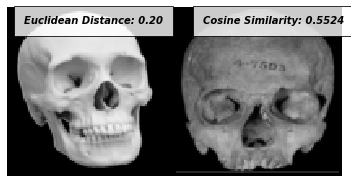

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/london-christopher-le-stocks-female/female.png


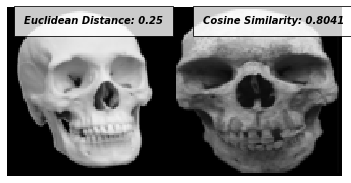

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/magdalen-winchester/magdalen-winchester.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


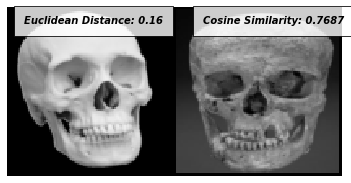

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/si-male-jamestown/A0385-LSG-APV-5041B-male-jamestown.png


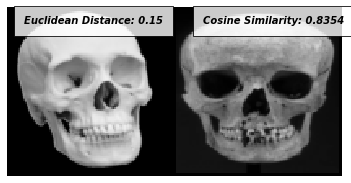

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/si-woman-1660/si-woman-1660-18CV271-JP-100.png


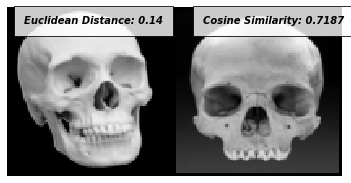

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/st-augustine-black-male/STAUGUSTINE-SI-385791-black-male.pn

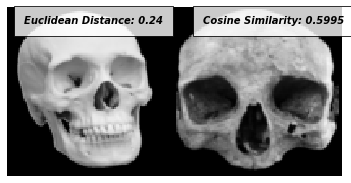

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-a/vendor-a.png


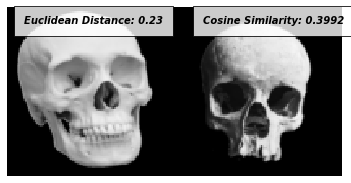

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-b/vendor-b.png


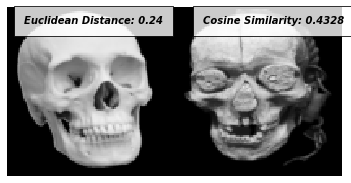

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-c/vendor-c.png


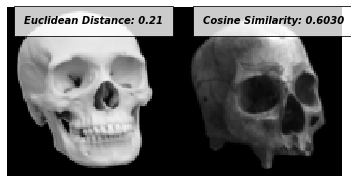

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-d/vendor_d.png


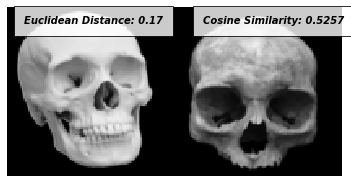

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-e/vendor-e-toulouse.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


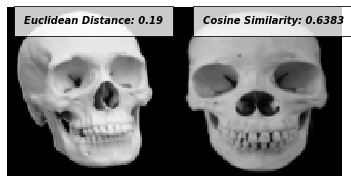

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-f/vendor-f-female-india.png


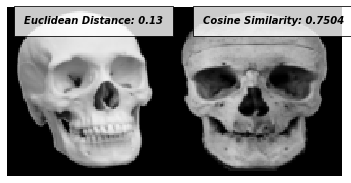

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-g/vendor-g.png


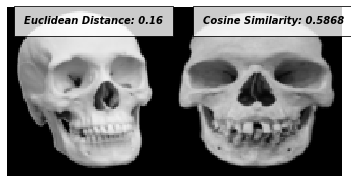

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-afr-american/bc-178-female-afr-american-removebg-preview-removebg-preview (1).png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-h/vendor-h-male-india.png
{'11324-dh': 0, 'RichardII

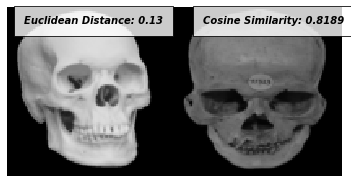

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m

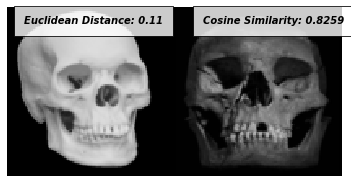

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/RichardIII/richardIII.png


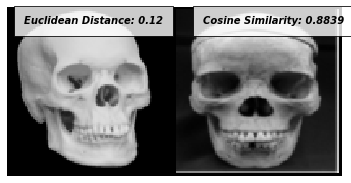

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/afr-f-moraitas/african-f-moraitas.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


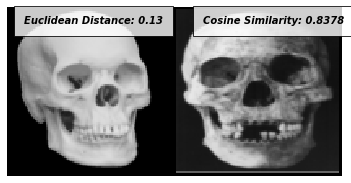

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-f-moraitas/asian-f-moraitas.png


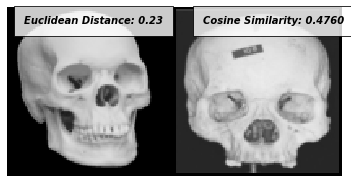

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-f-woo/asian-f-woo.png


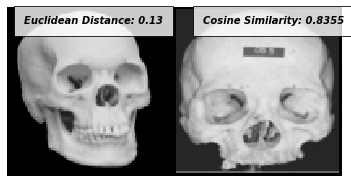

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-m-woo/asian-m-woo.png


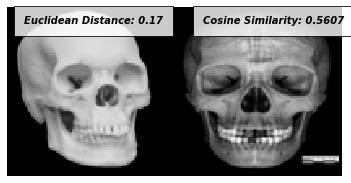

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-1-afr-am-f/cas-fig4-1-afr-am-f.png


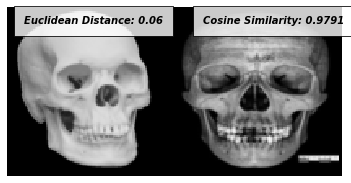

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-1-afr-am-m/cas-fig4-1-afr-am-m.png


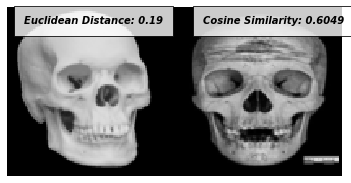

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-2-afr-f/cas-fig4-2-afr-f.png


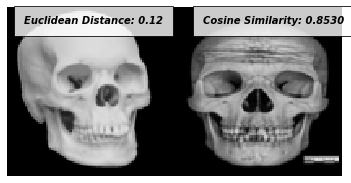

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-2-afr-m/cas-fig4-2-afr-m.png


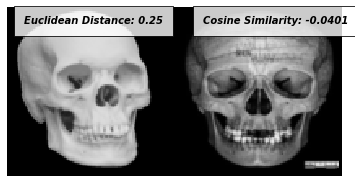

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-3-euro-am-f/cas-fig-4-3-euro-am-f.png


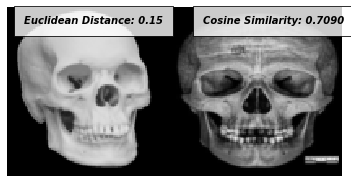

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-3-euro-am-m/cas-fig-4-3-euro-am-m.png


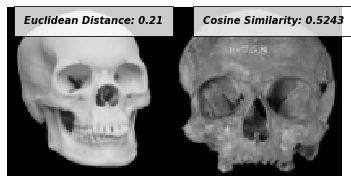

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/fountain-street-male/fountain-street-male-PA-SK-1559.png


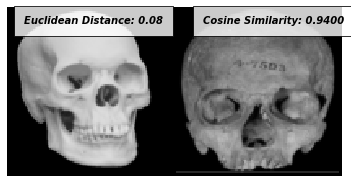

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/london-christopher-le-stocks-female/female.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


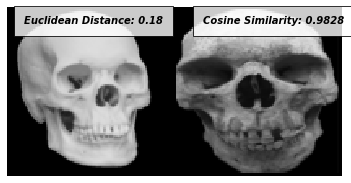

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}

Image 3: /content/data_copy_with_equal_augs/data/testing/magdalen-winchester/magdalen-winchester.png


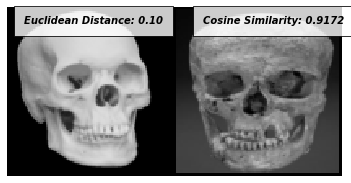

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/si-male-jamestown/A0385-LSG-APV-5041B-male-jamestown.png


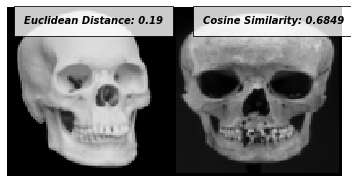

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/si-woman-1660/si-woman-1660-18CV271-JP-100.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


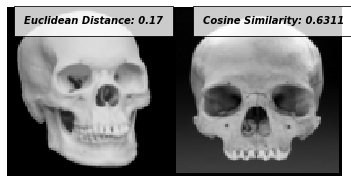

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/st-augustine-black-male/STAUGUSTINE-SI-385791-black-male.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


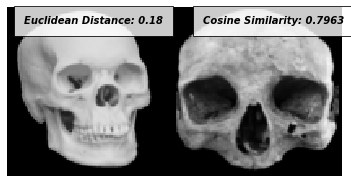

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-a/vendor-a.png


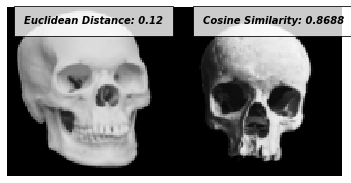

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-b/vendor-b.png


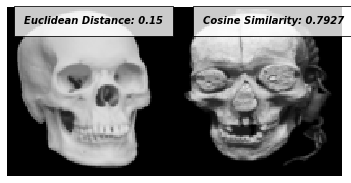

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-c/vendor-c.png


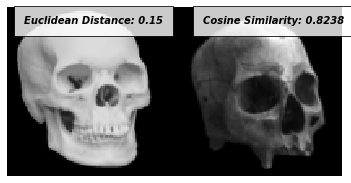

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-d/vendor_d.png


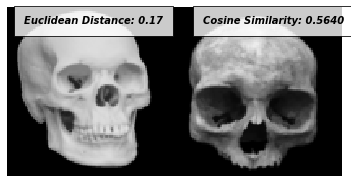

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-e/vendor-e-toulouse.png


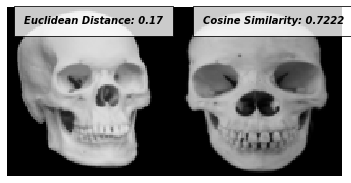

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-f/vendor-f-female-india.png


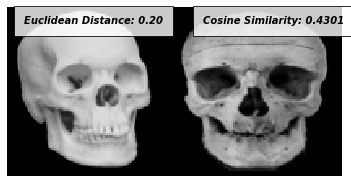

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-g/vendor-g.png


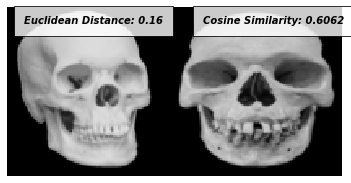

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-asian/bc-211-female-asian-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-h/vendor-h-male-india.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-mora

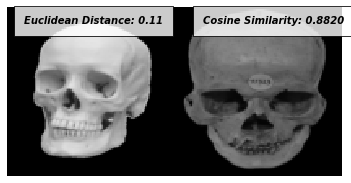

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/11324-dh/Screen_Shot_2019-06-20_at_1-removebg-preview.png


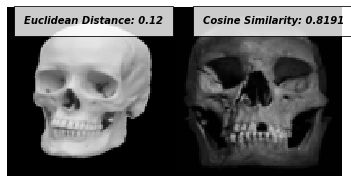

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/RichardIII/richardIII.png


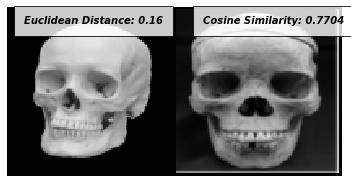

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/afr-f-moraitas/african-f-moraitas.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


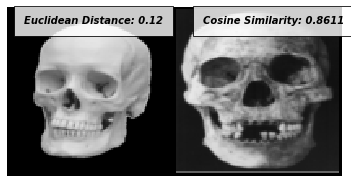

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-f-moraitas/asian-f-moraitas.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


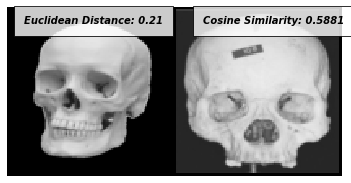

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-f-woo/asian-f-woo.png


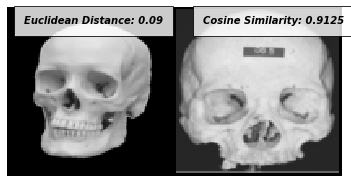

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-m-woo/asian-m-woo.png


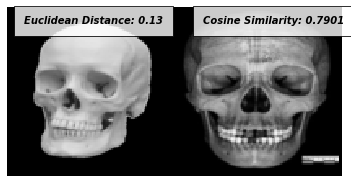

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-1-afr-am-f/cas-fig4-1-afr-am-f.png


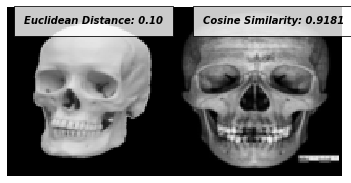

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-1-afr-am-m/cas-fig4-1-afr-am-m.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


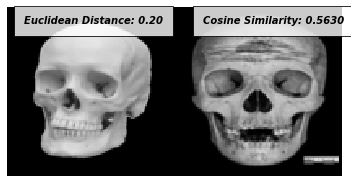

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-2-afr-f/cas-fig4-2-afr-f.png


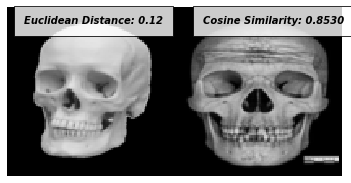

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-2-afr-m/cas-fig4-2-afr-m.png


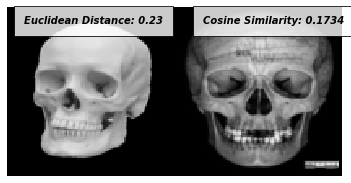

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-3-euro-am-f/cas-fig-4-3-euro-am-f.png


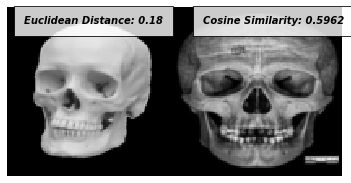

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-3-euro-am-m/cas-fig-4-3-euro-am-m.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


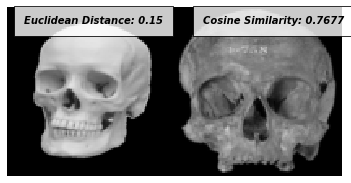

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/fountain-street-male/fountain-street-male-PA-SK-1559.png


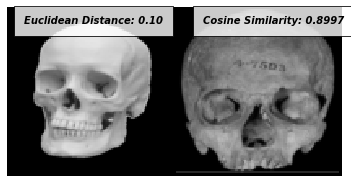

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/london-christopher-le-stocks-female/female.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


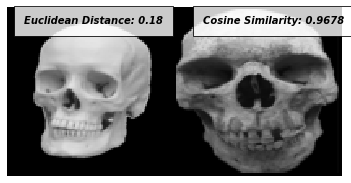

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/magdalen-winchester/magdalen-winchester.png


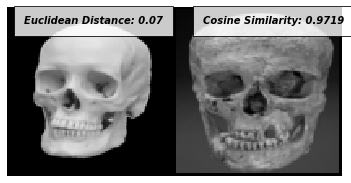

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/si-male-jamestown/A0385-LSG-APV-5041B-male-jamestown.png


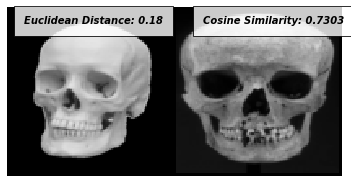

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/si-woman-1660/si-woman-1660-18CV271-JP-100.png


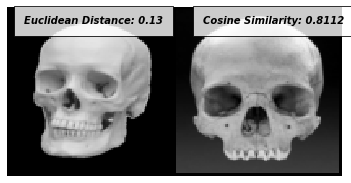

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/st-augustine-black-male/STAUGUSTINE-SI-385791-black-male.png


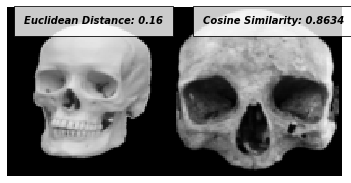

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-a/vendor-a.png


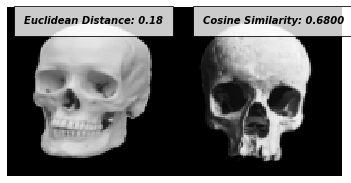

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-b/vendor-b.png


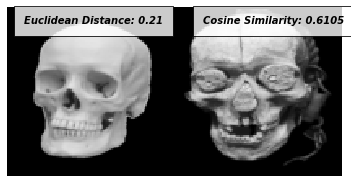

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-c/vendor-c.png


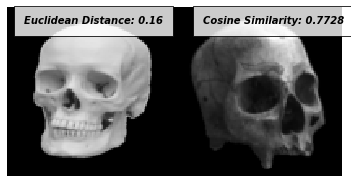

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-d/vendor_d.png


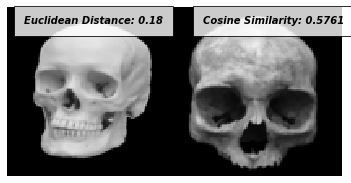

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-e/vendor-e-toulouse.png


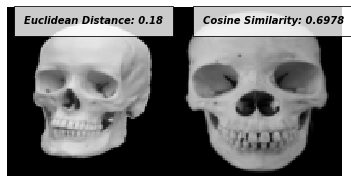

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-f/vendor-f-female-india.png


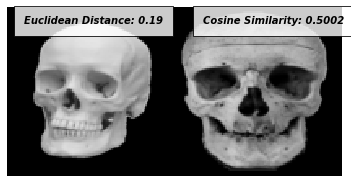

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-g/vendor-g.png


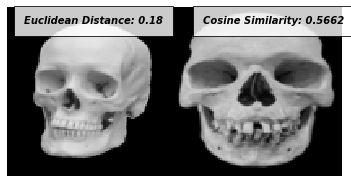

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-female-european/bcm-891-female-euro-removebg-preview-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-h/vendor-h-male-india.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-m

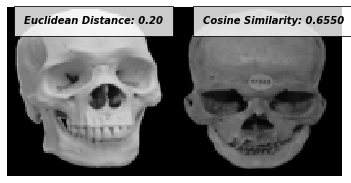

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/11324-dh/Screen_Shot_2019-06-20_at_1-removebg-preview.png


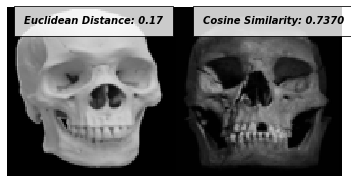

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/RichardIII/richardIII.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


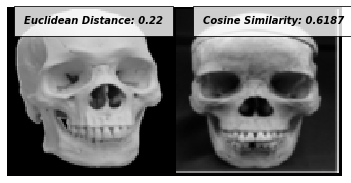

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/afr-f-moraitas/african-f-moraitas.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


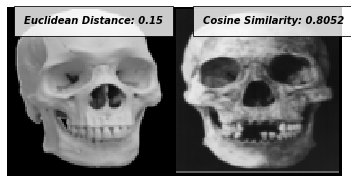

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-f-moraitas/asian-f-moraitas.png


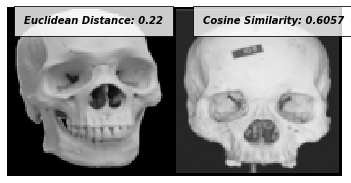

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-f-woo/asian-f-woo.png


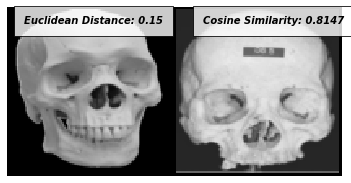

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-m-woo/asian-m-woo.png


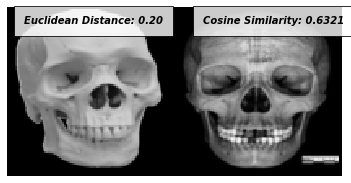

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-1-afr-am-f/cas-fig4-1-afr-am-f.png


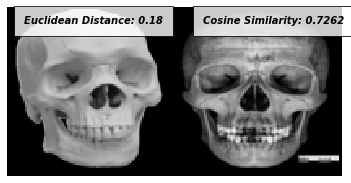

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-1-afr-am-m/cas-fig4-1-afr-am-m.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


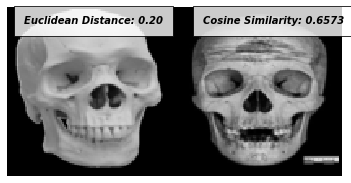

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-2-afr-f/cas-fig4-2-afr-f.png


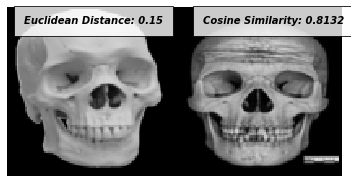

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-2-afr-m/cas-fig4-2-afr-m.png


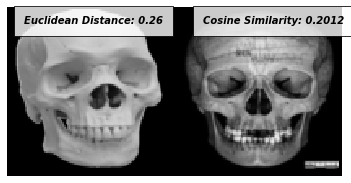

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-3-euro-am-f/cas-fig-4-3-euro-am-f.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


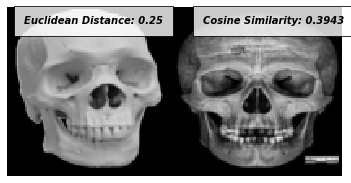

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-3-euro-am-m/cas-fig-4-3-euro-am-m.png


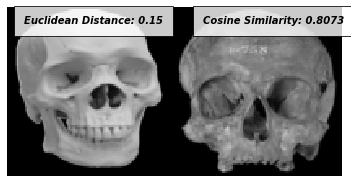

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/fountain-street-male/fountain-street-male-PA-SK-1559.png


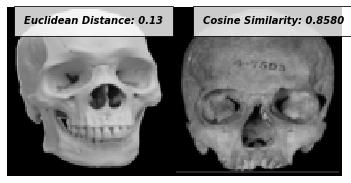

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/london-christopher-le-stocks-female/female.png


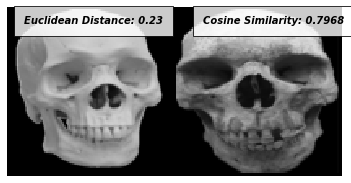

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/magdalen-winchester/magdalen-winchester.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


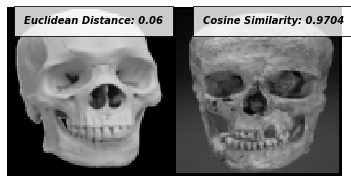

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/si-male-jamestown/A0385-LSG-APV-5041B-male-jamestown.png


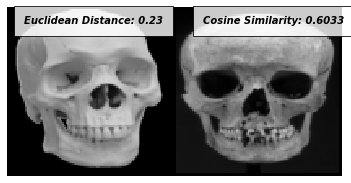

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}

Image 3: /content/data_copy_with_equal_augs/data/testing/si-woman-1660/si-woman-1660-18CV271-JP-100.png


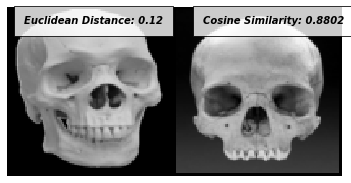

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/st-augustine-black-male/STAUGUSTINE-SI-385791-black-male.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


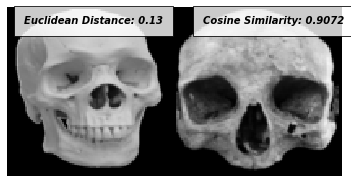

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-a/vendor-a.png


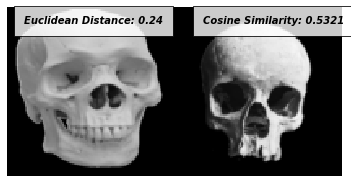

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-b/vendor-b.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


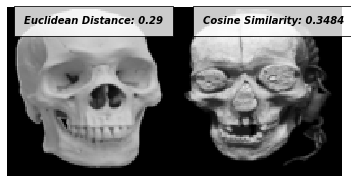

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-c/vendor-c.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


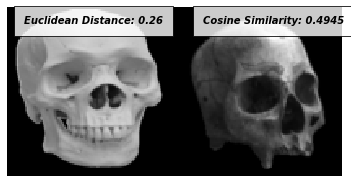

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-d/vendor_d.png


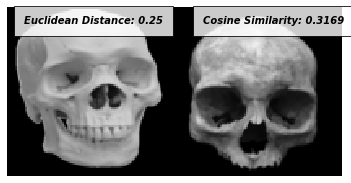

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-e/vendor-e-toulouse.png


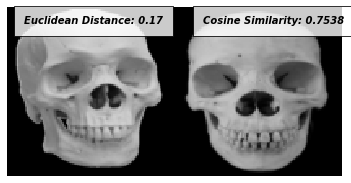

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-f/vendor-f-female-india.png


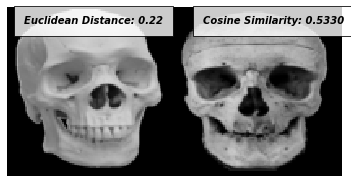

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-g/vendor-g.png


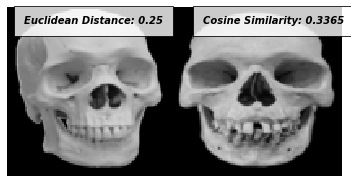

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-afr-american/african-american-male-bc-110-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-h/vendor-h-male-india.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraita

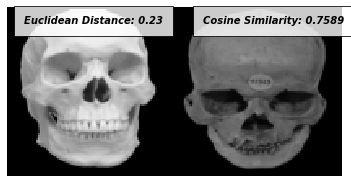

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/11324-dh/Screen_Shot_2019-06-20_at_1-removebg-preview.png


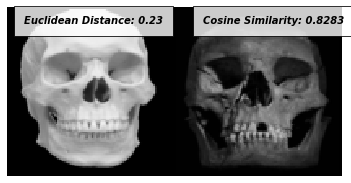

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/RichardIII/richardIII.png


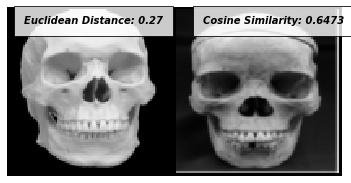

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/afr-f-moraitas/african-f-moraitas.png


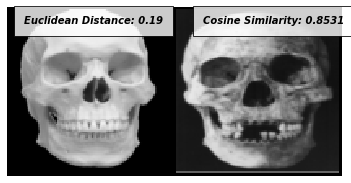

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-f-moraitas/asian-f-moraitas.png


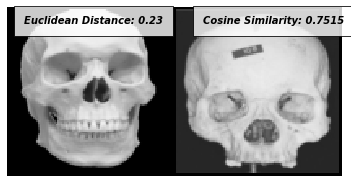

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-f-woo/asian-f-woo.png


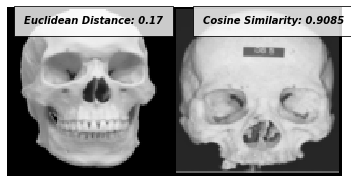

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-m-woo/asian-m-woo.png


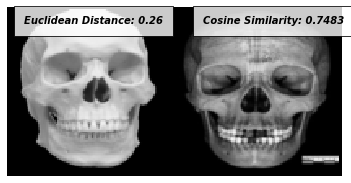

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-1-afr-am-f/cas-fig4-1-afr-am-f.png


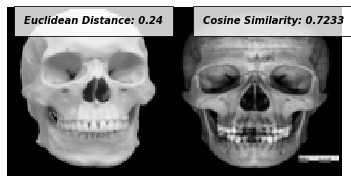

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-1-afr-am-m/cas-fig4-1-afr-am-m.png


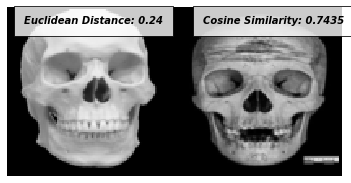

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-2-afr-f/cas-fig4-2-afr-f.png


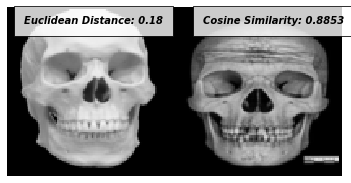

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-2-afr-m/cas-fig4-2-afr-m.png


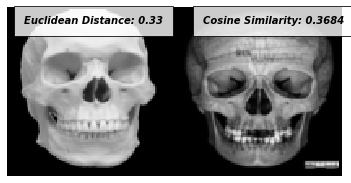

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-3-euro-am-f/cas-fig-4-3-euro-am-f.png


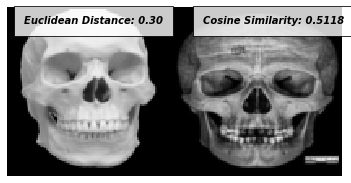

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-3-euro-am-m/cas-fig-4-3-euro-am-m.png


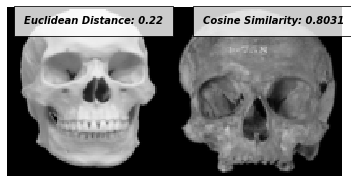

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/fountain-street-male/fountain-street-male-PA-SK-1559.png


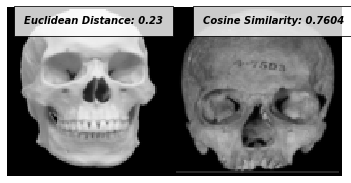

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/london-christopher-le-stocks-female/female.png


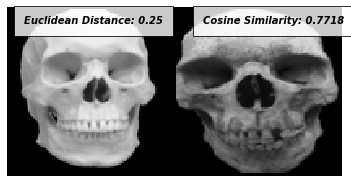

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/magdalen-winchester/magdalen-winchester.png


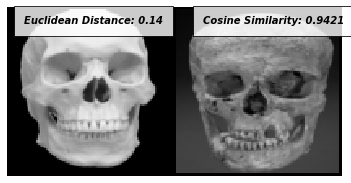

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/si-male-jamestown/A0385-LSG-APV-5041B-male-jamestown.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


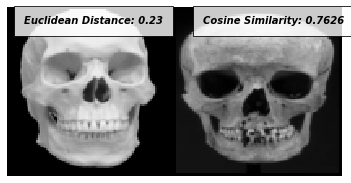

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/si-woman-1660/si-woman-1660-18CV271-JP-100.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


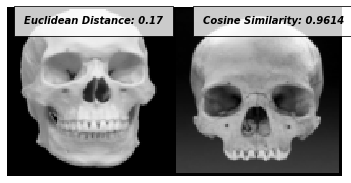

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/st-augustine-black-male/STAUGUSTINE-SI-385791-black-male.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


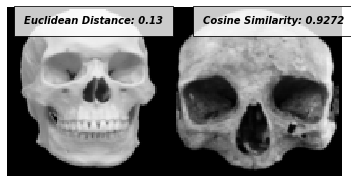

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}

Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-a/vendor-a.png


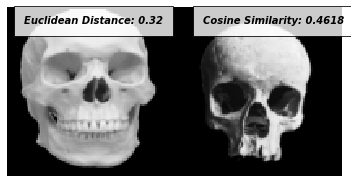

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-b/vendor-b.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


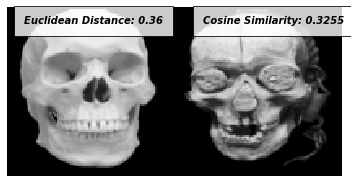

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-c/vendor-c.png


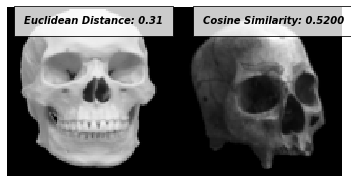

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-d/vendor_d.png


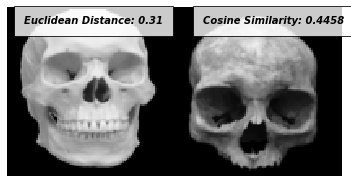

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-e/vendor-e-toulouse.png


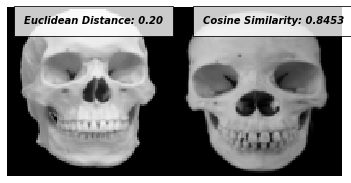

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-f/vendor-f-female-india.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


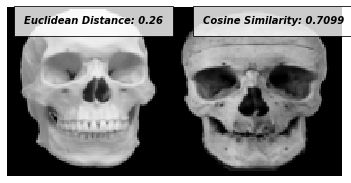

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-g/vendor-g.png


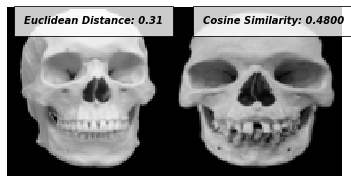

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-asian/male-asian-bc-253-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-h/vendor-h-male-india.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-mo

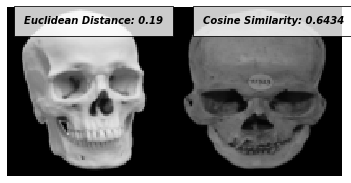

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/11324-dh/Screen_Shot_2019-06-20_at_1-removebg-preview.png


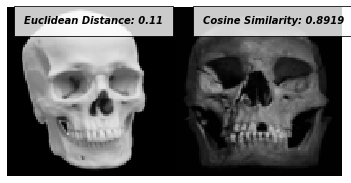

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/RichardIII/richardIII.png


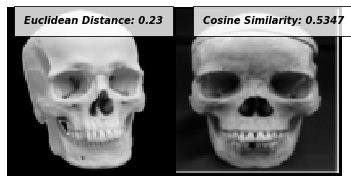

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/afr-f-moraitas/african-f-moraitas.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


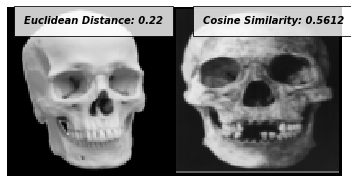

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-f-moraitas/asian-f-moraitas.png


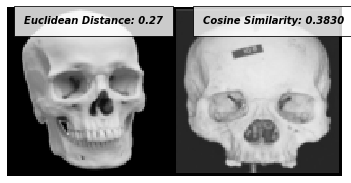

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/asian-f-woo/asian-f-woo.png


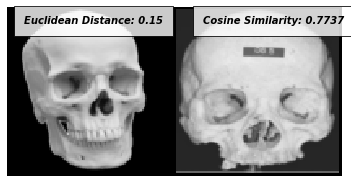

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}

Image 3: /content/data_copy_with_equal_augs/data/testing/asian-m-woo/asian-m-woo.png


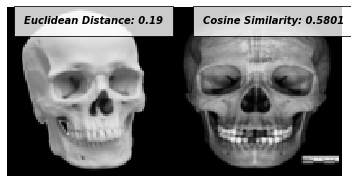

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-1-afr-am-f/cas-fig4-1-afr-am-f.png


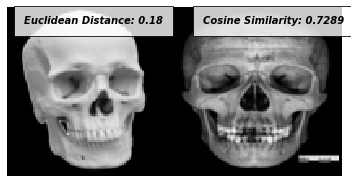

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-1-afr-am-m/cas-fig4-1-afr-am-m.png


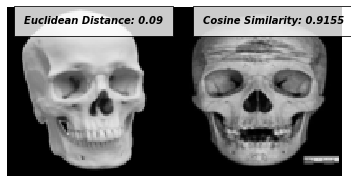

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-2-afr-f/cas-fig4-2-afr-f.png


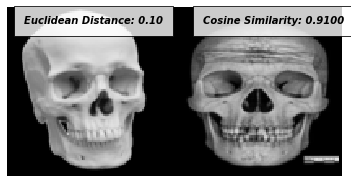

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-2-afr-m/cas-fig4-2-afr-m.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


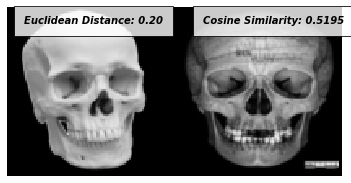

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-3-euro-am-f/cas-fig-4-3-euro-am-f.png


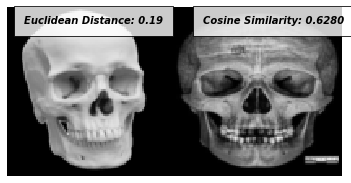

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/cas-fig-4-3-euro-am-m/cas-fig-4-3-euro-am-m.png


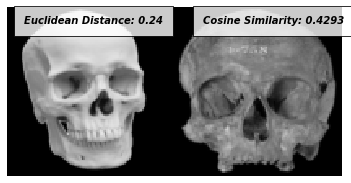

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/fountain-street-male/fountain-street-male-PA-SK-1559.png


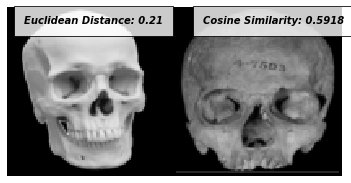

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/london-christopher-le-stocks-female/female.png


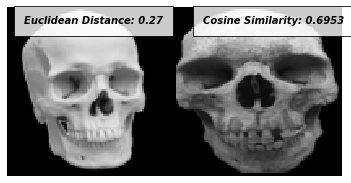

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/magdalen-winchester/magdalen-winchester.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


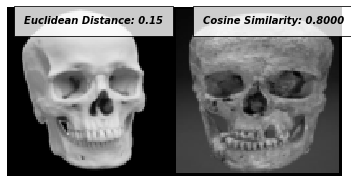

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/si-male-jamestown/A0385-LSG-APV-5041B-male-jamestown.png


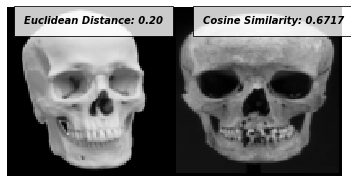

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/si-woman-1660/si-woman-1660-18CV271-JP-100.png


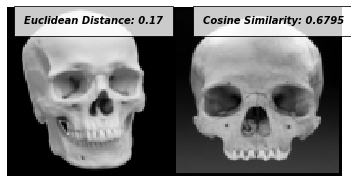

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/st-augustine-black-male/STAUGUSTINE-SI-385791-black-male.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}


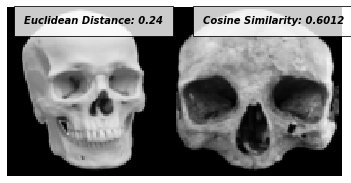

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-a/vendor-a.png


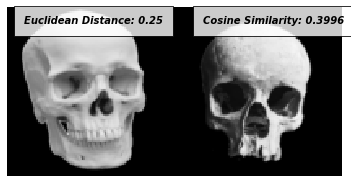

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-b/vendor-b.png


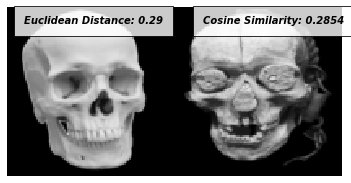

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-c/vendor-c.png


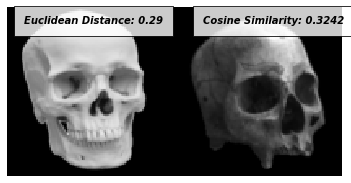

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-d/vendor_d.png


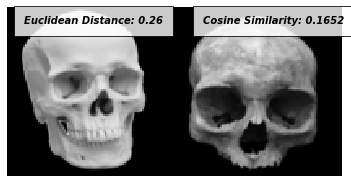

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-e/vendor-e-toulouse.png


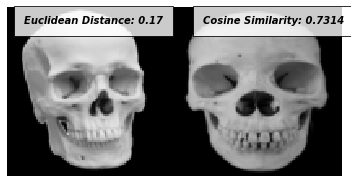

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-f/vendor-f-female-india.png


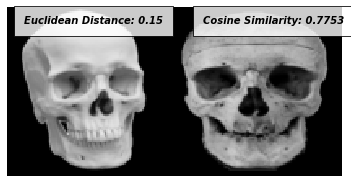

{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-g/vendor-g.png


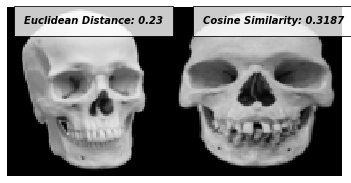

Image 1: /content/data_copy_with_equal_augs/data/testing/ref-male-european/european-male-bc-107-removebg-preview.png
Image 3: /content/data_copy_with_equal_augs/data/testing/vendor-h/vendor-h-male-india.png
{'11324-dh': 0, 'RichardIII': 1, 'afr-f-moraitas': 2, 'asian-f-moraitas': 3, 'asian-f-woo': 4, 'asian-m-woo': 5, 'cas-fig-4-1-afr-am-f': 6, 'cas-fig-4-1-afr-am-m': 7, 'cas-fig-4-2-afr-f': 8, 'cas-fig-4-2-afr-m': 9, 'cas-fig-4-3-euro-am-f': 10, 'cas-fig-4-3-euro-am-m': 11, 'fountain-street-male': 12, 'london-christopher-le-stocks-female': 13, 'magdalen-winchester': 14, 'ref-female-afr-american': 15, 'ref-female-asian': 16, 'ref-female-european': 17, 'ref-male-afr-american': 18, 'ref-male-asian': 19, 'ref-male-european': 20, 'si-male-jamestown': 21, 'si-woman-1660': 22, 'st-augustine-black-male': 23, 'vendor-a': 24, 'vendor-b': 25, 'vendor-c': 26, 'vendor-d': 27, 'vendor-e': 28, 'vendor-f': 29, 'vendor-g': 30, 'vendor-h': 31}
Finshed all anchor-unknown pair comparisons
{'11324-dh': 0,

In [0]:
# Init variable representing testing data's directory, 
# see Config section to specify path
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)

# Create the dataset, pairwise_siamese_dataset_anchors, with data from the 
# testing data
# Then, create a generator with pairwise_siamese_dataset-unknowns
triplet_siamese_dataset_anchors = PairwiseTestingSiameseNetworkDataset(
    imageFolderDataset=folder_dataset_test,
    transform=transforms.Compose([transforms.Resize((100,100)),
                                transforms.ToTensor()]),
    should_invert=False,
    anchor_iter_index=0, 
    anchor_file_identifier='ref-')

test_dataloader = DataLoader(
    triplet_siamese_dataset_anchors,
    num_workers=Config.num_generator_workers,
    batch_size=1,
    shuffle=False,
    worker_init_fn=worker_init_fn)

generator_anchor_images = iter(test_dataloader)

workers_terminated_outer = np.zeros(Config.num_generator_workers)
# Outer loop searches for anchors
for i in range(len(generator_anchor_images)):

    # Returns a found anchor's index, image, and filepath
    ind_anchor,worker_id_outer,anchor_image,_,anchor_filepath,_ = next(
        generator_anchor_images)
    #print(anchor_index.item())
    # Stop outer loop if index is out of bounds, no more potential anchors
    if not(0 in workers_terminated_outer):
        break

    if ind_anchor < 0:
        np.put(workers_terminated_outer, worker_id_outer, 1)
    else:
        #print(ind_anchor)
        # Create new dataset with a given known anchor's index
        # Then, create a generator with pairwise_siamese_dataset-unknowns
        triplet_siamese_dataset_unknowns = TripletTestingSiameseNetworkDataset(
            imageFolderDataset=folder_dataset_test,
            transform=transforms.Compose([transforms.Resize((100,100)),
                                          transforms.ToTensor()]),
            should_invert=False,
            anchor_index=ind_anchor, 
            anchor_file_identifier='ref-')
        #print(ind_anchor.item())
        #print(triplet_siamese_dataset_unknowns.anchor_iter_index)
        triplet_siamese_dataset_unknowns.anchor_iter_index = ind_anchor.item()
        #print(ind_anchor.item())
        #print(triplet_siamese_dataset_unknowns.anchor_iter_index)
        compare_dataloader = DataLoader(
            triplet_siamese_dataset_unknowns,
            num_workers=Config.num_generator_workers,
            batch_size=1,shuffle=False,
            worker_init_fn=worker_init_fn)
      
        generator_unknown_prov_images = iter(compare_dataloader)

        workers_terminated_inner = np.zeros(Config.num_generator_workers)
        # Inner loop pairs a known anchor with every image of unknown provenance
        for k in range(len(generator_unknown_prov_images)):
            # no_more_unknowns will return -1 if all pairs have been found
            no_more_unknowns,worker_id_inner,_,_,unknown_prov_image,_,unknown_prov_filepath = (
                next(generator_unknown_prov_images))
            
            #print("checking pos")
            #print(pos_generated_image)
            #print("checked pos")

            # Stop this inner loop if all anchor-unknown pairs for the current 
            # anchor image are found
            if not(0 in workers_terminated_inner):
                break

            if no_more_unknowns.item() < 0:
                np.put(workers_terminated_inner, worker_id_inner, 1)
            else:
                #print(anchor_filepath[0])
                
                pos_generated_image = generate_positive(anchor_filepath[0])
                pos_generated_image = pos_generated_image.convert("L")
                pos_generated_image = transforms.Compose([transforms.Resize((100,100)),
                                          transforms.ToTensor()])(pos_generated_image)
                pos_generated_image.unsqueeze_(0)
                #print(pos_generated_image)
                #print(anchor_image)
                

                #concatenated = torch.cat((anchor_image,pos_generated_image,unknown_prov_image),0)
                concatenated = torch.cat((anchor_image,unknown_prov_image),0)

                # Again getting rid of cuda for my Mac
                anchor_embed,pos_embed,neg_embed = net(
                    Variable(anchor_image).cuda(),
                    Variable(pos_generated_image).cuda(),
                    Variable(unknown_prov_image).cuda())
                # output1,output2 = net(Variable(x0),Variable(x1))
                #euclidean_distance = F.pairwise_distance(output1, output2)
                
                '''
                d_pos = torch.sum((anchor_embed - pos_embed)**2, 1)
                d_neg = torch.sum((anchor_embed - neg_embed)**2, 1)
                zero = torch.zeros([1], dtype=torch.float32)
                zero = zero.cuda()
                #print(2.0 + (d_pos - d_neg))
                loss_triplet = torch.max(zero, 1.0 + (d_pos - d_neg))
                #print(loss_triplet)
                loss_triplet = torch.mean(loss_triplet)
                '''
                '''
                euclidean_distance = anchor_embed - neg_embed
                euclidean_distance = (euclidean_distance.cpu()).detach()
                euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
                euclidean_distance = np.sqrt(euclidean_distance)
                '''

                euclidean_distance = F.pairwise_distance(anchor_embed, neg_embed)
                cosine_similarity = F.cosine_similarity(anchor_embed, neg_embed)

                #x = tf.constant(np.random.uniform(-1, 1, 10)) 
                #y = tf.constant(np.random.uniform(-1, 1, 10))
                #s = tf.compat.v1.losses.cosine_distance(anchor_embed.cpu(), neg_embed.cpu(), dim=0)
                #print(tf.Session().run(s))

                #print(type(anchor_embed))

                # Show the images:
                imshow(
                    torchvision.utils.make_grid(concatenated),
                    'Euclidean Distance: {:.2f}'.format(euclidean_distance.item()),
                    'Cosine Similarity: {:.4f}'.format(cosine_similarity.item()))

                #print(cosine_similarity)
                # Show the paths for the two images
                print('Image 1: {}'.format(anchor_filepath[0])) 
                #print('Image 2: Generated Positive') 
                print('Image 3: {}'.format(unknown_prov_filepath[0]))
                # Print out the results as a kind of table.
                # from tabulate import tabulate
                # print(tabulate([[p0, p1,euclidean_distance.item()]], 
                    # headers=['image1', 'image2','euclidean_distance']))
        
        # Ensures each worker generates unique pair
        # nth loop iteration 
        # * number of workers 
        # + this worker's ID (added in init)
        #next_index_to_check = Config.num_generator_workers+anchor_index.item()
        #anchor_index = torch.tensor(next_index_to_check)

print('Finshed all anchor-unknown pair comparisons')

---
# The End

The two code blocks below print out the structure of the neural network, and the version info of all of the loaded packages in this environment. This information is useful for replicating this notebook in the future.


In [0]:
from torchvision import models
model = net
print(model)

In [0]:
# watermark is not installed by default.
# the first time through, uncomment the two lines below
# then run the block.
#
#
# !pip install watermark
# %load_ext watermark
%watermark -v -m -p numpy,scipy,torchvision,PIL,tensorflow,torch -g